<a href="https://colab.research.google.com/github/vrodz/Perceptron-Simple2/blob/main/Practica_1_Ejercicio_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeavePOut
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

class PerceptronMulticapa:
    def __init__(self, nEntradas, capasOcultas, nSalidas, tazaAprendizaje, epochs):
        self.nEntradas = nEntradas
        self.capasOcultas = capasOcultas
        self.nSalidas = nSalidas
        self.tazaAprendizaje = tazaAprendizaje
        self.epochs = epochs
        self.pesos = [np.random.rand(capasOcultas[0], nEntradas)]
        self.sesgos = [np.zeros(capasOcultas[0])]

        for i in range(1, len(capasOcultas)):
            self.pesos.append(np.random.rand(capasOcultas[i], capasOcultas[i-1]))
            self.sesgos.append(np.zeros(capasOcultas[i]))

        self.pesos.append(np.random.rand(nSalidas, capasOcultas[-1]))
        self.sesgos.append(np.zeros(nSalidas))

    def sigmoid(self, x):
        return 1/(1+np.exp(-x))

    def sigmoidDerivada(self, x):
        return x*(1-x)

    def relu(self, x):
        return np.maximum(0, x)

    def reluDerivada(self, x):
        return np.where(x>0, 1, 0)

    def softmax(self, x):
        e_x = np.exp(x - np.max(x))
        return e_x/e_x.sum(axis=0)

    def softmaxDerivada(self, s):
        return s*(1 - s)

    def feedForward(self, entradas):
        capasSalida = [entradas]
        for i in range(len(self.pesos)):
            capaEntrada = np.dot(self.pesos[i], capasSalida[-1]) + self.sesgos[i]
            if i == len(self.pesos) - 1:
                capaSalida = self.softmax(capaEntrada)
            else:
                capaSalida = self.relu(capaEntrada)
            capasSalida.append(capaSalida)
        return capasSalida

    def entranamiento(self, datosEntrenamiento, capas):
        for epoch in range(self.epochs):
            for entradas, capa in zip(datosEntrenamiento, capas):
                capasSalida = self.feedForward(entradas)
                predicciones = capasSalida[-1]
                errores = [-capa * np.log(predicciones)]
                deltas = [errores[0] * self.softmaxDerivada(predicciones)]
                for i in range(len(self.pesos) - 2, -1, -1):
                    error = deltas[0].dot(self.pesos[i + 1])
                    errores.insert(0, error)
                    deltas.insert(0, errores[0] * self.reluDerivada(capasSalida[i + 1]))
                for i in range(len(self.pesos)):
                    self.pesos[i] += self.tazaAprendizaje * np.outer(deltas[i], capasSalida[i])
                    self.sesgos[i] += self.tazaAprendizaje * deltas[i]

    def prediccion(self, entradas):
        capasSalida = self.feedForward(entradas)
        predicciones = capasSalida[-1]
        return np.where(predicciones == np.max(predicciones), 1, -1)


In [ ]:
class Separador:
    def __init__(self, nEntradas, capasOcultas, nSalidas, tazaAprendizaje, epochs):
        self.nEntradas = nEntradas
        self.capasOcultas = capasOcultas
        self.nSalidas = nSalidas
        self.tazaAprendizaje = tazaAprendizaje
        self.epochs = epochs
        self.datosEntrenamiento = None
        self.capasEntrenamiento = None
        self.datosPrueba = None
        self.capasPrueba = None
        self.archivoDatos = 'irisbin.csv'
        self.Perceptron = PerceptronMulticapa(self.nEntradas, self.capasOcultas, self.nSalidas, self.tazaAprendizaje, self.epochs);

    def leerArchivoDatos(self):
        datos = []
        capas = []
        archivo = open(self.archivoDatos, mode='r')
        lineas = archivo.readlines()
        for linea in lineas:
            cadenas = linea[:len(linea)-1].split(',')
            x1 = float(cadenas[0])
            x2 = float(cadenas[1])
            x3 = float(cadenas[2])
            x4 = float(cadenas[3])
            y1 = int(cadenas[4])
            y2 = int(cadenas[5])
            y3 = int(cadenas[6])
            datos.append([x1, x2, x3, x4])
            capas.append([y1, y2, y3])
        archivo.close()
        self.datosEntrenamiento, self.capasEntrenamiento, self.datosPrueba, self.capasPrueba = self.PerturbacionCapas(datos, capas)

    def PerturbacionCapas(self, datos, capas):
        x1 = np.array(datos)
        x2 = np.array(capas)
        escalar = StandardScaler()
        x1 = escalar.fit_transform(x1)
        porcentaje = 0.8
        nDatos = int(len(datos) * porcentaje)
        datosEntrenamiento = np.array(x1[:nDatos])
        datosPrueba = np.array(x1[nDatos:])
        capasEntrenamiento = np.array(x2[:nDatos])
        capasPrueba = np.array(x2[nDatos:])
        return datosEntrenamiento, capasEntrenamiento, datosPrueba, capasPrueba

    def Entrenamiento(self):
        self.Perceptron.entranamiento(self.datosEntrenamiento, self.capasEntrenamiento)

    def TipoFlor(self, prediccion, real):
        if(prediccion[0] ==  real[0] and prediccion[1] ==  real[1] and prediccion[2] ==  real[2]):
            if(prediccion[0] == -1 and prediccion[1] == -1 and prediccion[2] == 1):
                return "Setosa"
            elif(prediccion[0] == -1 and prediccion[1] == 1 and prediccion[2] == -1):
                return "Versicolor"
            elif(prediccion[0] == 1 and prediccion[1] == -1 and prediccion[2] == -1):
                return "Virginica"
        else:
            return "None"

    def leaveOneOut(self, pe=1):
        x1, x2 = self.datosEntrenamiento, self.capasEntrenamiento
        aciertos = []
        lpo = LeavePOut(pe)
        for indicesEntrenamiento, indicesPrueba in lpo.split(x1):
            x1Entrenamiento, x1Prueba = x1[indicesEntrenamiento], x1[indicesPrueba]
            x2Entrenamiento, x2Prueba = x2[indicesEntrenamiento], x2[indicesPrueba]
            modelo = PerceptronMulticapa(self.nEntradas, self.capasOcultas, self.nSalidas, self.tazaAprendizaje, self.epochs);
            modelo.entranamiento(x1Entrenamiento, x2Entrenamiento)
            predicciones = []
            for entradas in x1Prueba:
                prediccion = modelo.prediccion(entradas)
                predicciones.append(prediccion)
            precision = accuracy_score(x2Prueba, predicciones)
            aciertos.append(precision)
        precisionPromedio = sum(aciertos)/len(aciertos)
        desviacionEstandar = np.std(aciertos)
        porcentajeErrorEsperado = (1 - precisionPromedio) * 100
        print(f"Precision prueba: {precisionPromedio * 100:.2f}%")
        print(f"Desviacion Estándar: {desviacionEstandar * 100:.2f}%")
        print(f"Error: {porcentajeErrorEsperado}%")

    def ProbarFlores(self):
        prediccionesCorrectas = 0
        prediccionesTotal = len(self.datosPrueba)
        prediccionCapas = []
        coloresFlores = ['pink', 'purple', 'black']
        tiposFlores = ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
        marcadores = ['x', 'o', '+']
        for entradas, capa in zip(self.datosPrueba, self.capasPrueba):
            prediccion = self.Perceptron.prediccion(entradas)
            prediccionCapas.append(prediccion)
            if self.TipoFlor(prediccion, capa) != "None":
                plt.scatter(entradas[0], entradas[1], color=coloresFlores[np.argmax(capa)])
                prediccionesCorrectas += 1
        precision = prediccionesCorrectas / prediccionesTotal
        self.leaveOneOut()
        #self.leaveOneOut(2)
        for i, capa in enumerate(tiposFlores):
            plt.scatter([], [], color=coloresFlores[i], label=capa, marker=marcadores[i], s=25)
        plt.legend()
        plt.xlabel('PC2')
        plt.ylabel('PC1')
        plt.title('Flores Iris')
        plt.show()

Precision prueba: 83.33%
Desviacion Estándar: 37.27%
Error: 16.666666666666664%


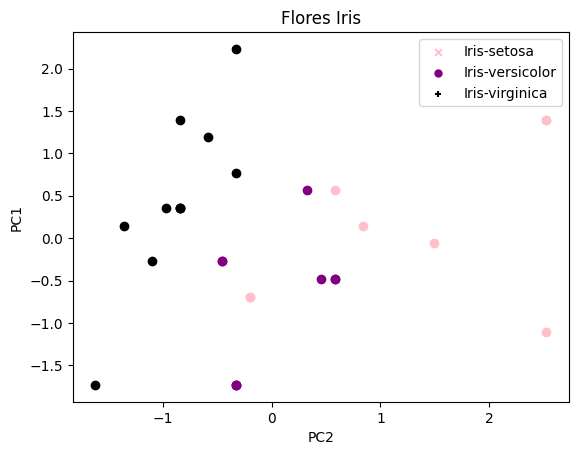

In [ ]:
floresIris = Separador(nEntradas = 4, capasOcultas = [8], nSalidas = 3, tazaAprendizaje = 0.1, epochs = 100)
floresIris.leerArchivoDatos()
floresIris.Entrenamiento()
floresIris.ProbarFlores()